In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import timedelta
from datetime import datetime

import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [3]:
print('pandas version :', pd.__version__, '\n')
print('numpy version :', np.__version__, '\n')
print('matplotlib version :', matplotlib.__version__, '\n')
print('seaborn version :', sns.__version__, '\n')
print('sklearn version :', sklearn.__version__, '\n')
print('yellowbrick version : ', yellowbrick.__version__)

pandas version : 1.2.4 

numpy version : 1.19.5 

matplotlib version : 3.3.4 

seaborn version : 0.11.2 

sklearn version : 1.0.2 

yellowbrick version :  1.3.post1


# Fonctions

In [4]:
# Par défaut, on va se placer 6 mois avant la dernière commande
def choix_df(data, date_debut=date(2016, 9, 4),
             date_fin=date(2018, 3, 3)):
    """
    Prend un Dataframe qui va être filtrer selon la date de début
    et la date de fin indiquées en paramètres. Les colonnes du
    dataframe seront groupées selon certaines fonctions (moyenne,
    somme, compter et minimum). Enfin, ajoute une colonne
    correspondant à la fréquence d'achat d'un client sur la
    période étudiée.

            Parameters:
                data : dataframe à utiliser
                date_debut (date object) : date de début du filtrage
                date_fin (date object) : date de fin du filtrage
    """
    data = df0.copy()

    # On commence par ne garder que la période qui nous intéresse
    data = data[(data['order_purchase_timestamp'] >= date_debut)
                & (data['order_purchase_timestamp'] <= date_fin)]

    # Date de la dernière commande du jeu de données
    jour_max = data['order_purchase_timestamp'].max()

    # Date de la première commande du jeu de données
    jour_min = data['order_purchase_timestamp'].min()

    # Nombre de jour au total
    nb_jours = (jour_max - jour_min).days

    # Temps entre la commande du client et la dernière date du jeu de données
    data['time_delta'] = (data['order_purchase_timestamp'].max()
                          - data['order_purchase_timestamp'])

    # On transforme "time_delta" pour n'avoir que les jours en nombres entiers
    data['time_delta'] = data['time_delta'].dt.days

    # On crée les colonnes que l'on veut
    data = (data.groupby('customer_unique_id').agg(
        nb_commandes=('order_id', 'count'), score_moy=('review_score',
                                                       'mean'),
        nb_paiements=('payment_installments', 'mean'),
        nb_produits=('order_item_id', 'mean'),
        recence=('time_delta', 'min'),
        montant_total=('order_total_cost', 'sum')))

    # On veut des nombres entiers pour certaines colonnes
    for col in ['score_moy', 'nb_paiements', 'nb_produits']:
        data[col] = data[col].astype(int)

    # On crée une colonne de fréquence d'achat
    data['frequence_achat'] = round(data['nb_commandes'] / nb_jours, 4)

    return(data)

In [5]:
# Preprocessing
def preprocessing(data):
    """
    Prend un DataFrame et passe les colonnes les plus concentrées sur des
    faibles valeurs au logarithme. Prend ensuite toutes les features numériques
    pour les centrer (on soustrait la moyenne de la feature) et les réduire
    (diviser par l'écart-type de la feature) à l'aide d'un StandardScaler.

            Parameters:
                data : DataFrame à utiliser
    """
    # On passe quelques colonnes au log
    transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)

    cols_to_log = ['nb_commandes', 'nb_paiements', 'nb_produits',
                   'montant_total', 'frequence_achat']

    for col in cols_to_log:
        data[col] = transformer.fit_transform(data[col])

    # On standardise nos colonnes
    cols_to_scale = ['nb_commandes', 'score_moy', 'nb_paiements',
                     'nb_produits', 'recence', 'montant_total',
                     'frequence_achat']

    scaler = StandardScaler()

    data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [6]:
# Elbow plot
def elbow_k_means(data):
    """
    Prend un Dataframe et lui applique un algorithme de clustering
    (k means) pour différents nombres de cluster (entre 2 et 9) et
    retourne le temps mis pour appliquer chacun des modèles à nos
    données ainsi que la valeur de distortion de chaque clustering sous
    la forme de graphique.
    La valeur de distortion correspond à la somme des distances au carré
    entre un point et le centre de son cluster. Le point d'inflexion
    de la courbe sera indiqué (si existant).

            Parameters:
                data : DataFrame à utiliser
    """
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2, 10))

    visualizer.fit(data)
    visualizer.show()

In [7]:
# Silhouette plot
def silhouette_k_means(data, model):
    """
    Prend un Dataframe et lui applique l'algorithme de clustering
    souhaité. Calcule la densité de chaque cluster (comprise entre
    -1 et 1) en utilisant la coefficient de silhouette de chaque
    échantillon. Ce coefficient est la différence entre la distance
    moyenne intra-cluster et la distance moyenne avec le cluster
    le plus proche pour chaque échantillon, le tout normalisé par la
    valeur maximale.

            Parameters:
                data : DataFrame à utiliser
                model : modèle de clustering à appliquer
    """
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(data)
    visualizer.show()

# Preprocessing initial

In [8]:
# On charge notre jeu de données
df0 = pd.read_csv('P5_01_frequence.csv')
df0 = df0.drop(columns=['Unnamed: 0'])

In [9]:
# On transforme notre colonne de date en datetime
df0['order_purchase_timestamp'] = pd.to_datetime(
    df0['order_purchase_timestamp'], format='%Y-%m-%d')

# On enlève les heures - minutes - secondes, on ne garde que la date
df0['order_purchase_timestamp'] = df0['order_purchase_timestamp'].dt.date

Dans un premier temps, on va utiliser notre fonction *choix_df* pour avoir nos données entre septembre 2016 (les données les plus anciennes) et mars 2018 (6 mois avant les données les plus récentes).

Dans un second temps, on pourra rajouter des données petit à petit (une semaine de données en plus à chaque itération). Cela nous permettra de comparer l'évolution des clusters dans le temps avec comme base les 18 premiers mois.

In [10]:
# Toutes les données sauf les 6 derniers mois
df_ini = choix_df(df0)

In [11]:
# On passe quelques colonnes au log
transformer_ini = FunctionTransformer(func=np.log, inverse_func=np.exp)

cols_to_log = ['nb_commandes', 'nb_paiements', 'nb_produits',
               'montant_total', 'frequence_achat']

for col in cols_to_log:
    df_ini[col] = transformer_ini.fit_transform(df_ini[col])

df_ini.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,3,2.079442,0.0,358,4.456902,-6.319969
0000f6ccb0745a6a4b88665a16c9f078,0.0,4,1.386294,0.0,142,3.775516,-6.319969
0004aac84e0df4da2b147fca70cf8255,0.0,5,1.791759,0.0,109,5.282645,-6.319969


In [12]:
# On standardise nos colonnes
cols_to_scale = ['nb_commandes', 'score_moy', 'nb_paiements',
                 'nb_produits', 'recence', 'montant_total',
                 'frequence_achat']

scaler_ini = StandardScaler()

df_ini[cols_to_scale] = scaler_ini.fit_transform(df_ini[cols_to_scale])

df_ini.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,-0.172036,-0.790676,1.655709,-0.307924,1.754817,-0.320600,-0.172362
0000f6ccb0745a6a4b88665a16c9f078,-0.172036,-0.045677,0.800601,-0.307924,-0.146589,-1.134669,-0.172362
0004aac84e0df4da2b147fca70cf8255,-0.172036,0.699322,1.300807,-0.307924,-0.437081,0.665935,-0.172362


On crée une copie de notre jeu de données sans aucun preprocessing pour pouvoir avoir des meilleures représentations visuelles.

In [13]:
# On revient sur nos changements pour avoir les bonnes valeurs
df = df_ini.copy()

df[cols_to_scale] = scaler_ini.inverse_transform(df[cols_to_scale])

for col in cols_to_log:
    df[col] = transformer_ini.inverse_transform(df[col])

df.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1.0,3.0,8.0,1.0,358.0,86.22,0.0018
0000f6ccb0745a6a4b88665a16c9f078,1.0,4.0,4.0,1.0,142.0,43.62,0.0018
0004aac84e0df4da2b147fca70cf8255,1.0,5.0,6.0,1.0,109.0,196.89,0.0018


# Modèle final : RFM + Score

On ne garde que nos variables RFM (récence, fréquence et montant) et le score moyen des commandes. Comme vu précédemment, le nombre optimal de clusters sera de 5 et ils peuvent être expliqués facilement.

In [14]:
# On ne garde que les 4 variables que l'on veut
df_score = df_ini[['score_moy', 'recence', 'montant_total', 'frequence_achat']]

k_means_score = KMeans(n_clusters=5, init='k-means++',  random_state=24)

In [15]:
# On crée notre colonne de cluster
y = k_means_score.fit_predict(df_score)
df['cluster'] = y

On refait des graphiques pour avoir une aide visuelle.

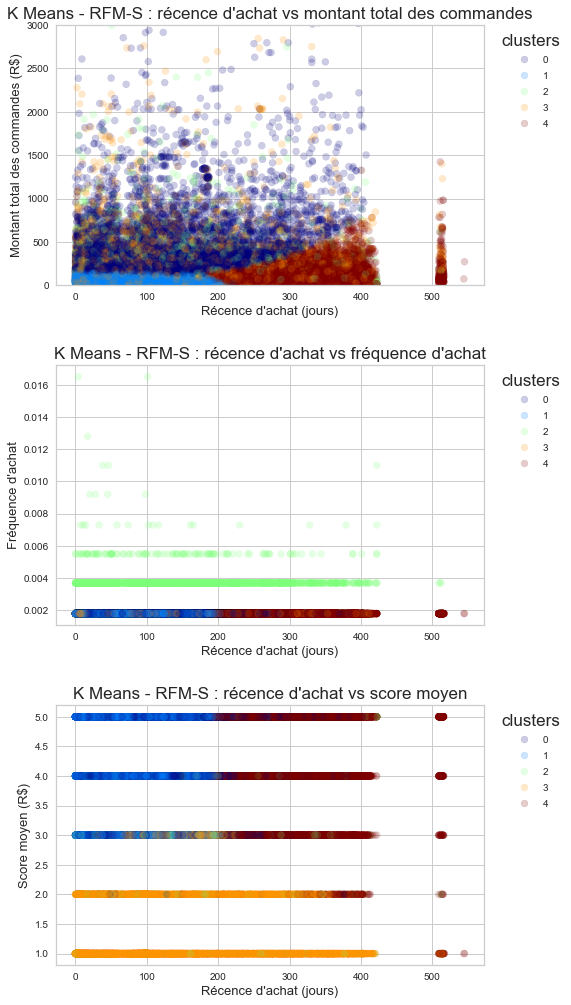

In [16]:
clusters_score = k_means_score.labels_

fig, ax = plt.subplots(3, figsize=(8, 15))
fig.tight_layout(pad=5.0)

# X: recence, Y: montant_total
ax[0].set_ylim(0, 3000)
ax[0].set_title(
    "K Means - RFM-S : récence d'achat vs montant total des commandes",
    fontsize=17)
ax[0].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[0].set_ylabel("Montant total des commandes (R$)", fontsize=13)
fig1 = ax[0].scatter(df.iloc[:, 4], df.iloc[:, 5],
                     c=clusters_score, cmap='jet', alpha=0.2)

ax[0].legend(*fig1.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: frequence_achat
ax[1].set_title(
    "K Means - RFM-S : récence d'achat vs fréquence d'achat",
    fontsize=17)
ax[1].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[1].set_ylabel("Fréquence d'achat", fontsize=13)
fig2 = ax[1].scatter(df.iloc[:, 4], df.iloc[:, 6],
                     c=clusters_score, cmap='jet', alpha=0.2)

ax[1].legend(*fig2.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

# X: recence, Y: score_moy
ax[2].set_title(
    "K Means - RFM-S : récence d'achat vs score moyen",
    fontsize=17)
ax[2].set_xlabel("Récence d'achat (jours)", fontsize=13)
ax[2].set_ylabel("Score moyen (R$)", fontsize=13)
fig3 = ax[2].scatter(df.iloc[:, 4], df.iloc[:, 1],
                     c=clusters_score, cmap='jet', alpha=0.2)

ax[2].legend(*fig3.legend_elements(), title='clusters',
             bbox_to_anchor=(1.2, 1), title_fontsize=17)

plt.show()

# Fréquence de mise à jour

On va ajouter une semaine de données à chaque fois à nos données et regarder l'évolution de l'Adjusted Rand Index Score (ARI). Nous allons comparer le clustering de nos jeux de données avec le modèle de clustering initial et le preprocessing initial avec le clustering des jeux de données avec un nouveau modéle et un nouveau preprocessing.

In [17]:
# On se place 6 mois avant la dernière date
list_of_df_old = []

for i in range(0, 196, 7):
    list_of_df_old.append(
        choix_df(df0, date(2016, 9, 4),
                 date_fin=date(2018, 3, 3) + timedelta(days=i)))

# On utilise le preprocessing initial
for i in range(0, 27):
    for col in cols_to_log:
        list_of_df_old[i][col] = transformer_ini.transform(
            list_of_df_old[i][col])

    list_of_df_old[i][cols_to_scale] = scaler_ini.transform(
        list_of_df_old[i][cols_to_scale])

# On garde RFM + Score
    list_of_df_old[i] = list_of_df_old[i].drop(
        columns=['nb_commandes', 'nb_paiements', 'nb_produits'])

# Clustering avec l'ancien preprocessing
    y = k_means_score.predict(list_of_df_old[i])
    list_of_df_old[i]['old_cluster'] = y

In [18]:
# On recommence avec un nouveau preprocessing
list_of_df = []

for i in range(0, 196, 7):
    list_of_df.append(choix_df(df0, date(2016, 9, 4),
                               date_fin=date(2018, 3, 3) + timedelta(days=i)))

# On réalise un nouveau preprocessing de nos données
for i in range(0, 27):
    preprocessing(list_of_df[i])

# On garde RFM + Score
    list_of_df[i] = list_of_df[i].drop(columns=['nb_commandes',
                                                'nb_paiements', 'nb_produits'])

# Clustering avec le nouveau preprocessing
    y = k_means_score.fit_predict(list_of_df[i])
    list_of_df[i]['new_cluster'] = y

In [19]:
# On vérifie qu'on a bien 28 semaines
# (6 mois + la 1ère semaine + les derniers jours)
len(list_of_df)

28

Nous pouvons maintenant calculer l'ARI afin de comparer l'évolution de nos clusters dans le temps.

In [20]:
# On calcule le score ARI
list_ari = []

for i in range(0, 27):
    list_ari.append(round(adjusted_rand_score(
        list_of_df[i]['new_cluster'], list_of_df_old[i]['old_cluster']),
                          4))

On vérifie si notre liste de score a des valeurs qui diminuent à chaque itération ou non.

In [21]:
list_ari_sorted = sorted(list_ari, reverse=True)

if(set(list_ari) == set(list_ari_sorted)):
    print('Les scores diminuent à chaque itération.')
else:
    print('Les scores ne diminuent pas forcément à chaque itération')

Les scores diminuent à chaque itération.


Les scores diminuant à chaque itération, nous avons juste à regarder quand est-ce que ces scores passent sous la barre d'un certain seuil. Nous allons regarder combien de semaines il faut pour que notre score soit inférieur à 0.8 (80% des individus sont dans les mêmes clusters que défini initialement).

In [22]:
good_values_ari = []
for value in list_ari:
    if value >= 0.8:
        good_values_ari.append(value)

# On enlève 1 car on a notre valeur initiale
rythme = len(good_values_ari) - 1

# Fréquence de mise à jour :
print(f'Il faudra mettre à jour le clustering toutes les {rythme} semaines.')

Il faudra mettre à jour le clustering toutes les 11 semaines.


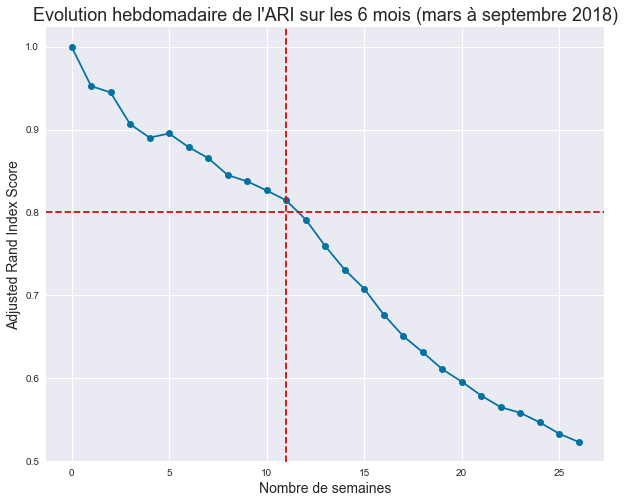

In [23]:
# Graphiquement
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 8))
plt.plot(list_ari, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axvline(x=rythme, color='r', linestyle='--')

plt.title(
    "Evolution hebdomadaire de l'ARI sur les 6 mois (mars à septembre 2018)",
    fontsize=18)
plt.xlabel('Nombre de semaines', fontsize=14)
plt.ylabel('Adjusted Rand Index Score', fontsize=14)
plt.show()